In [45]:
repo_directory = '/Users/iaincarmichael/Dropbox/Research/law/law-net/'

data_dir = '/Users/iaincarmichael/Documents/courtlistener/data/'

import numpy as np
import sys
import matplotlib.pyplot as plt


# graph package
import igraph as ig

# our code
sys.path.append(repo_directory + 'code/')
from setup_data_dir import setup_data_dir, make_subnetwork_directory
from pipeline.download_data import download_bulk_resource, download_master_edgelist, download_scdb
from helpful_functions import case_info

from stats.viz import *
from stats.dim_reduction import *
from stats.linear_model import *

sys.path.append(repo_directory + 'vertex_metrics_experiment/code/')
from rankscore_experiment_sort import *
from rankscore_experiment_LR import *
from make_tr_edge_df import *


# which network to download data for
network_name = 'scotus' # 'federal', 'ca1', etc


# some sub directories that get used
raw_dir = data_dir + 'raw/'
subnet_dir = data_dir + network_name + '/'
text_dir = subnet_dir + 'textfiles/'


# jupyter notebook settings
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
G = ig.Graph.Read_GraphML(subnet_dir + network_name +'_network.graphml')

# in-degree vs out-degree

In [52]:
outdegs = np.array(G.outdegree())
indegs = np.array(G.indegree())


# to_keep = (indegs >= 1) & (outdegs >= 1)
# indegs = indegs[to_keep]
# outdegs = outdegs[to_keep]

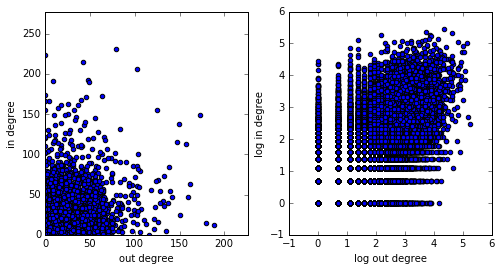

In [53]:
plt.figure(figsize=[8,4])
plt.subplot(1,2,1)
plt.scatter(outdegs, indegs)
plt.xlabel('out degree')
plt.ylabel('in degree')
plt.xlim([0, 1.2*max(outdegs)])
plt.ylim([0, 1.2*max(indegs)])

plt.subplot(1,2,2)
plt.scatter(np.log(outdegs), np.log(indegs))
plt.xlabel('log out degree')
plt.ylabel('log in degree')

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.209
Model:                            OLS   Adj. R-squared:                  0.209
Method:                 Least Squares   F-statistic:                     7355.
Date:                Fri, 30 Dec 2016   Prob (F-statistic):               0.00
Time:                        15:26:35   Log-Likelihood:            -1.0887e+05
No. Observations:               27885   AIC:                         2.177e+05
Df Residuals:                   27883   BIC:                         2.178e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          4.2557      0.087     49.123      0.0

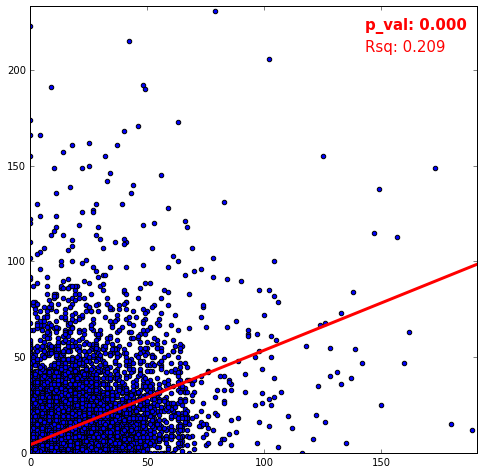

In [54]:
get_SLR(outdegs, indegs)

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.290
Model:                            OLS   Adj. R-squared:                  0.290
Method:                 Least Squares   F-statistic:                 1.140e+04
Date:                Fri, 30 Dec 2016   Prob (F-statistic):               0.00
Time:                        15:27:02   Log-Likelihood:                -38137.
No. Observations:               27885   AIC:                         7.628e+04
Df Residuals:                   27883   BIC:                         7.629e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.8027      0.009     85.451      0.0

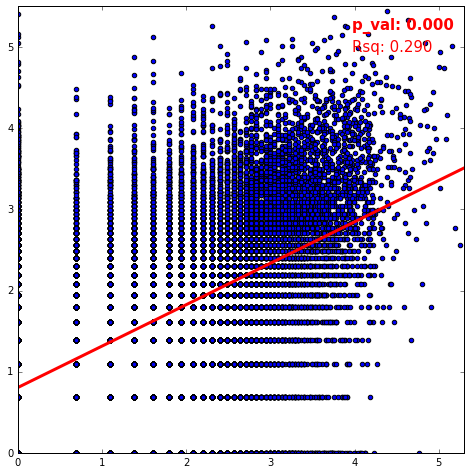

In [56]:
get_SLR(np.log(outdegs + 1), np.log(indegs + 1))

# other metrics

In [33]:
%time d_pagerank = G.pagerank()

CPU times: user 47 ms, sys: 6.85 ms, total: 53.8 ms
Wall time: 55.5 ms


In [29]:
%time u_pagerank = G.as_undirected().pagerank()

CPU times: user 498 ms, sys: 50.8 ms, total: 548 ms
Wall time: 565 ms


In [21]:
%time d_betweenness = G.betweenness(directed=True)

CPU times: user 1min 7s, sys: 987 ms, total: 1min 8s
Wall time: 1min 9s


In [26]:
%time u_betweenness = G.as_undirected().betweenness(directed=False)

CPU times: user 6min 45s, sys: 8.38 s, total: 6min 53s
Wall time: 7min 8s


In [22]:
%time d_closeness =  G.closeness(mode="IN", normalized=True)

CPU times: user 43.2 s, sys: 1.34 s, total: 44.6 s
Wall time: 46.1 s


In [25]:
%time u_closeness = G.as_undirected().closeness(normalized=True)

CPU times: user 3min 27s, sys: 3.69 s, total: 3min 30s
Wall time: 3min 41s


In [30]:
%time d_eigen = G.eigenvector_centrality()

CPU times: user 1min 32s, sys: 896 ms, total: 1min 33s
Wall time: 1min 34s


In [31]:
%time u_eigen = G.as_undirected().eigenvector_centrality()

CPU times: user 493 ms, sys: 14.9 ms, total: 508 ms
Wall time: 513 ms


In [120]:
%time hubs = G.hub_score()

CPU times: user 339 ms, sys: 6.08 ms, total: 345 ms
Wall time: 349 ms


In [121]:
%time authorities = G.authority_score()

CPU times: user 316 ms, sys: 2.48 ms, total: 319 ms
Wall time: 319 ms


In [176]:
indegree = G.indegree()
outdegree = G.outdegree()
degree = G.degree()

In [177]:
df = pd.DataFrame(index=G.vs['name'])

df['year'] = G.vs['year']

df['indegree'] = indegree
df['outdegree'] = outdegree
df['degree'] = degree
df['d_pagerank'] = d_pagerank
df['u_pagerank'] = u_pagerank
df['d_betweenness'] = d_betweenness
df['u_betweenness'] = u_betweenness
df['d_closeness'] = d_closeness
df['u_closeness'] = u_closeness
df['d_eigen'] = d_eigen
df['u_eigen'] = u_eigen
df['hubs'] = hubs
df['authorities'] = authorities

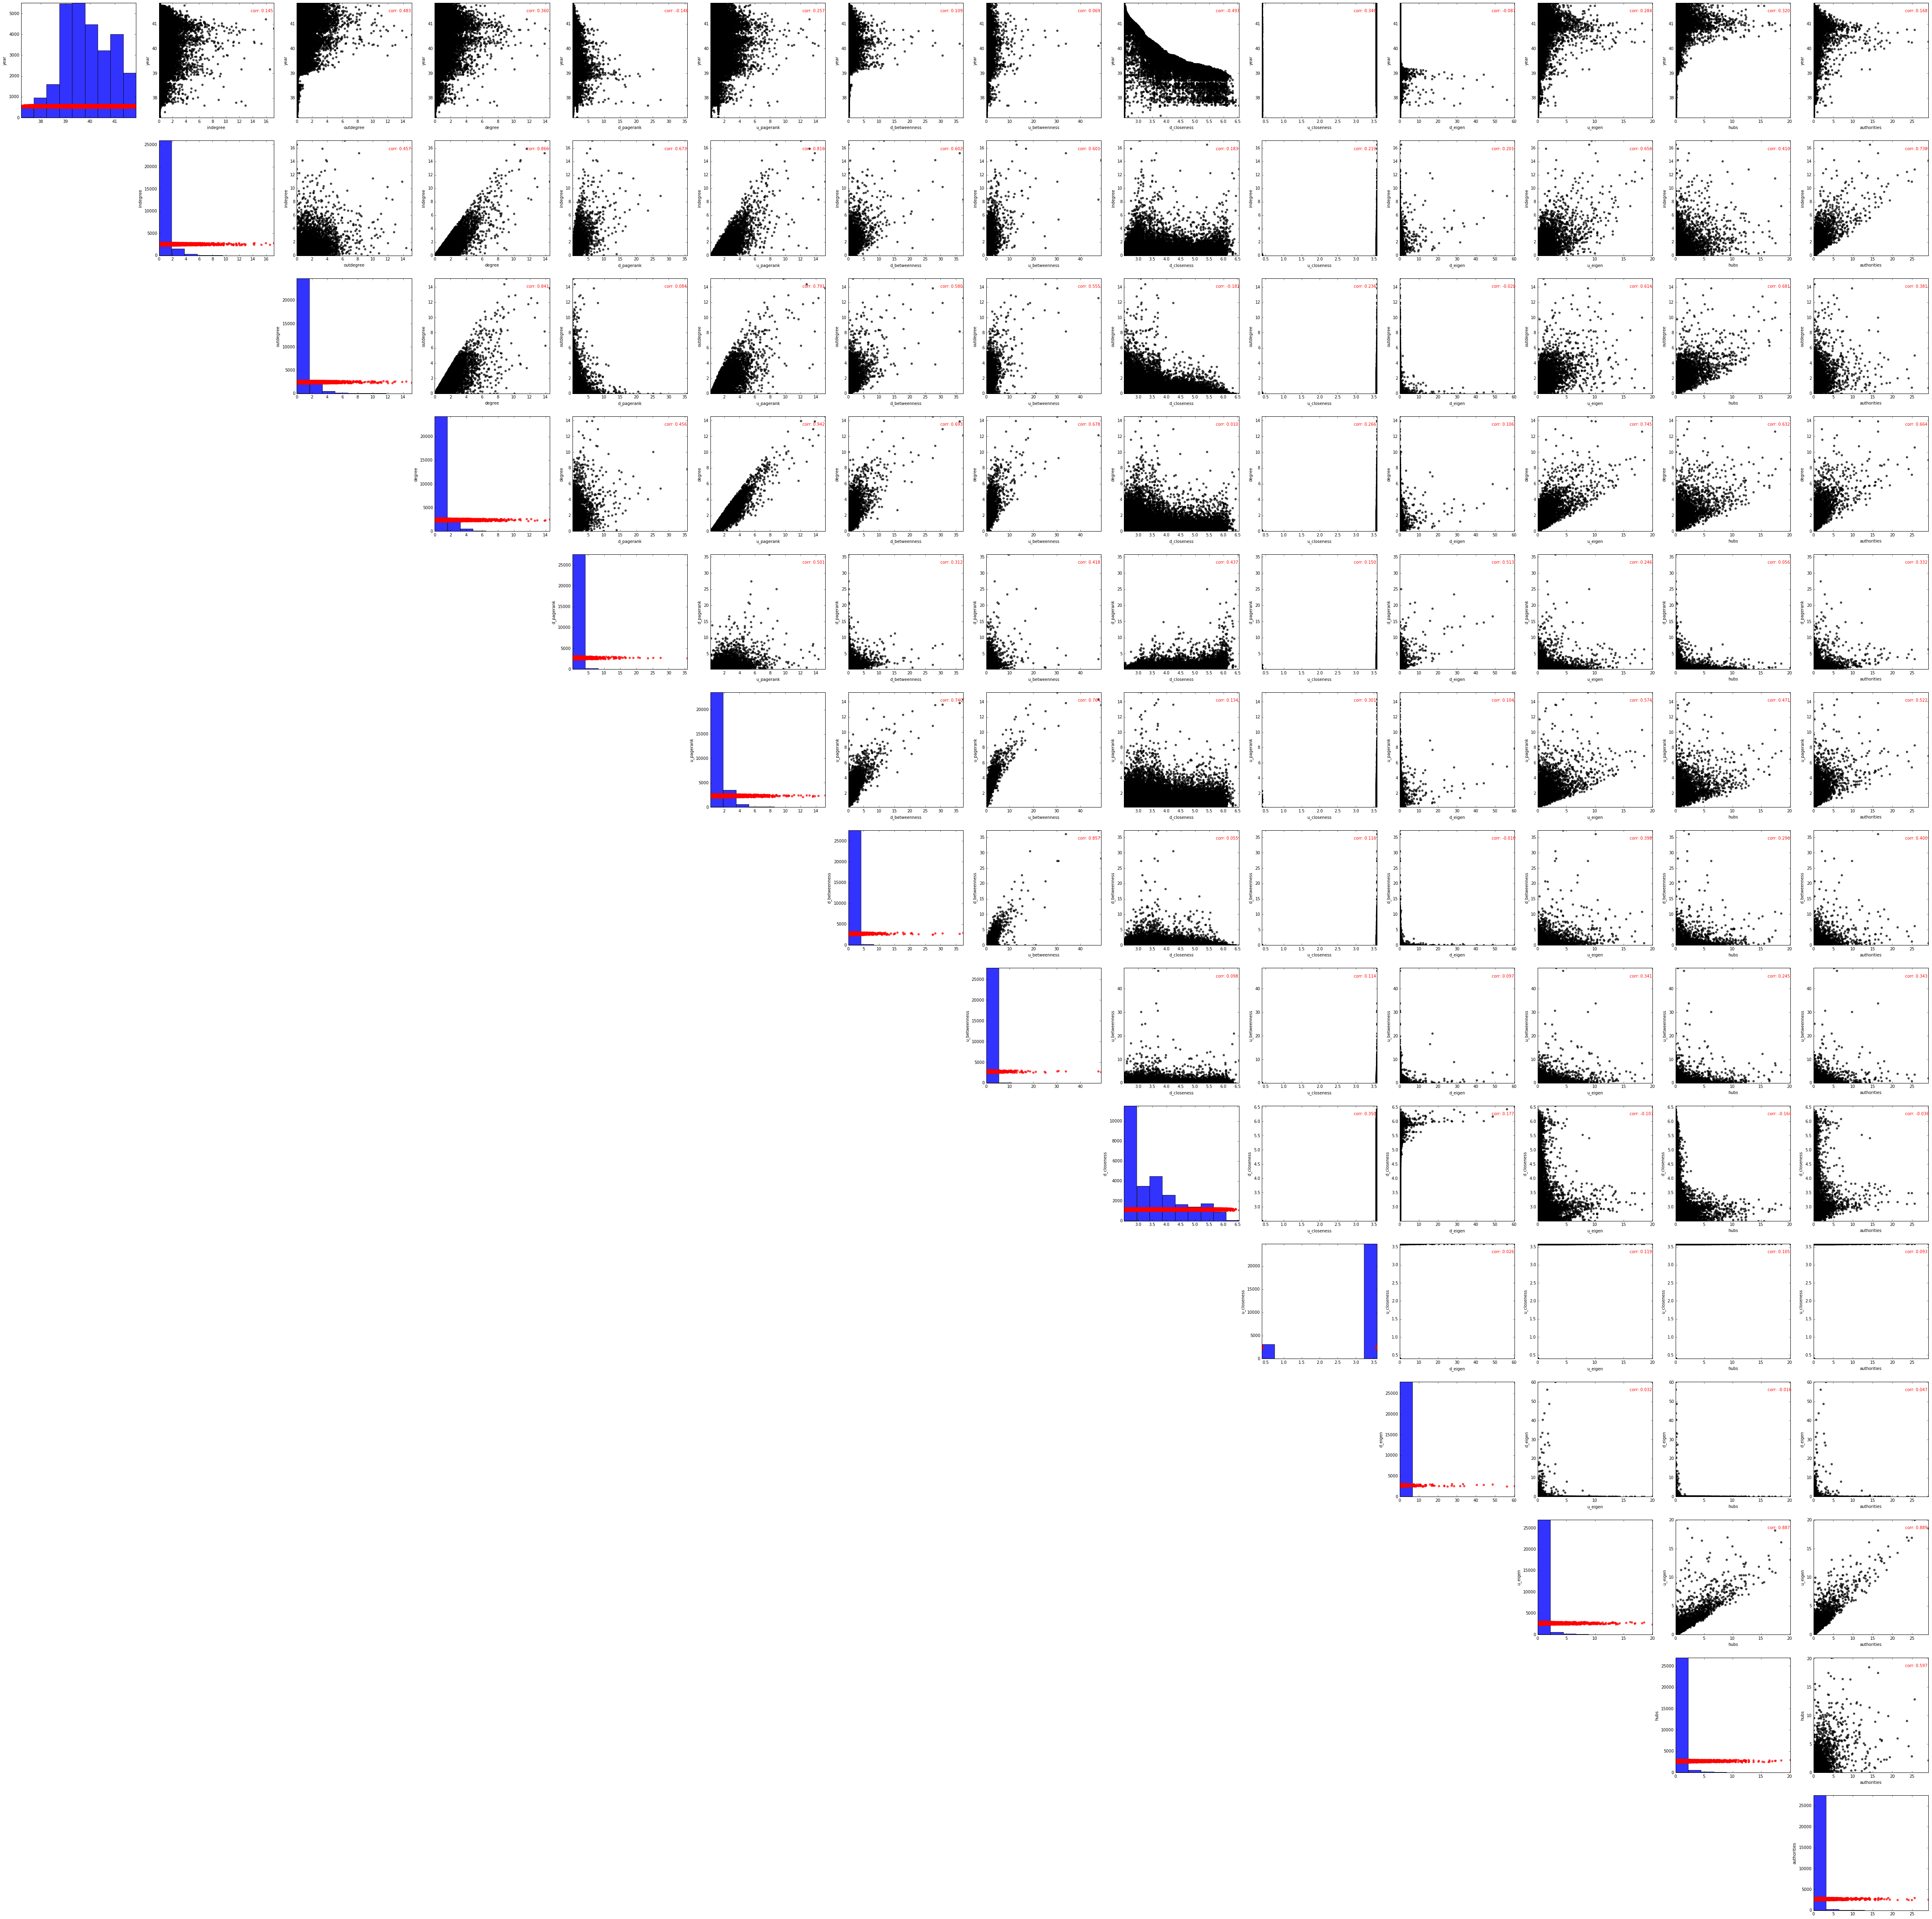

In [178]:
plot_scatter_matrix(df.apply(lambda c: c/np.std(c)))

In [179]:
U, D, V = get_PCA(df, scale=True)

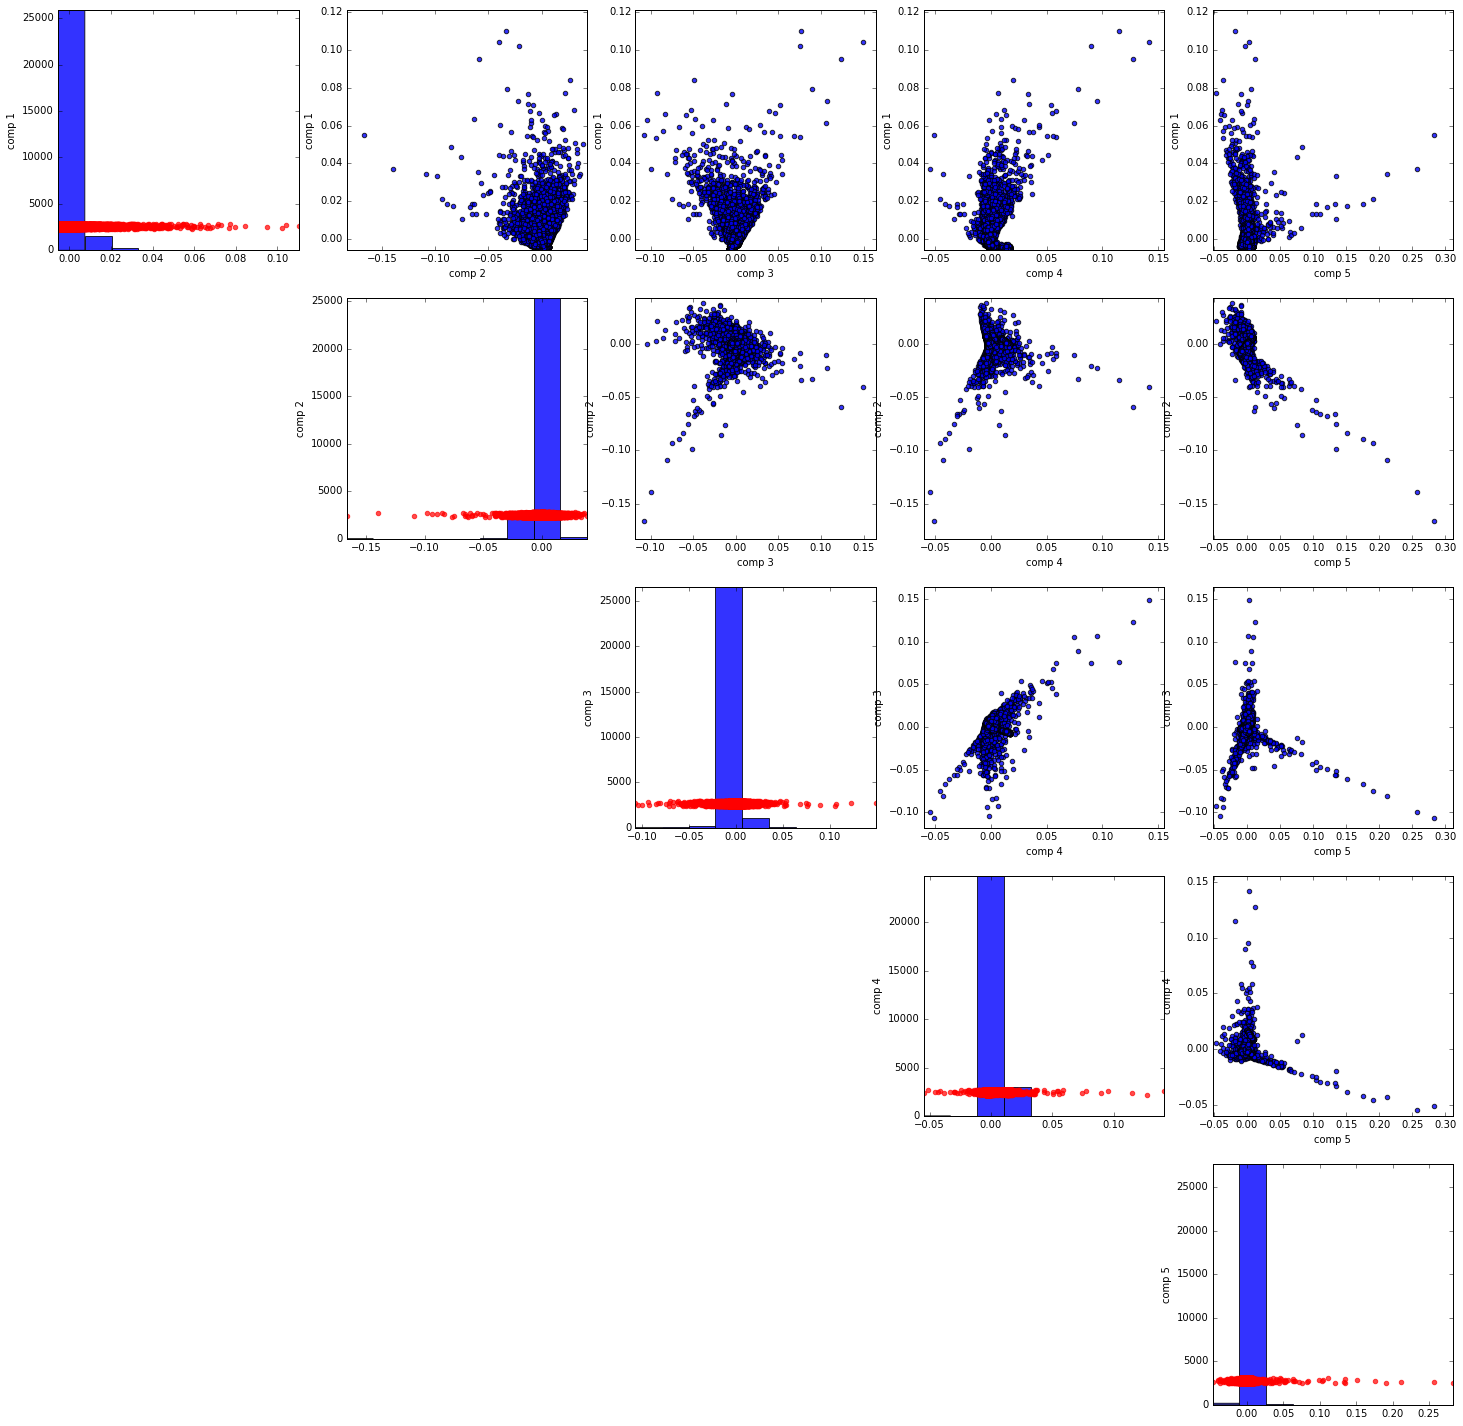

In [180]:
plot_scores(U,
            start=1,
            n_comp=5,
            title='')

# issue area

In [146]:
# map types to issues
type_to_issue = {'procedural': [1, 4, 6, 9],
                 'substantive': [2, 3, 5, 7, 8, 12, 14],
                 'other': [10, 11, 13, 0]}

# map issues to type
issue_to_type = {i: '' for i in range(13 + 1)}
for t in type_to_issue.keys():
    for i in type_to_issue[t]:
        issue_to_type[i] = t

In [182]:
# create type
G.vs['issueArea'] = [int(i) for i in G.vs['issueArea']]
G.vs['type'] = [issue_to_type[i] for i in G.vs['issueArea']]

# add to data frame
df['issueArea'] = G.vs['issueArea']
df['type'] = G.vs['type']

In [183]:
# get type subsets
df_sub = df[df['type'] == 'substantive']
df_pro = df[df['type'] == 'procedural']
df_oth = df[df['type'] == 'other']

print 'num substantive: %d' % df_sub.shape[0]
print 'num procedural: %d' % df_pro.shape[0]
print 'num other: %d' % df_oth.shape[0]

num substantive: 16891
num procedural: 9733
num other: 1261


In [184]:
df.columns

Index([u'year', u'indegree', u'outdegree', u'degree', u'd_pagerank',
       u'u_pagerank', u'd_betweenness', u'u_betweenness', u'd_closeness',
       u'u_closeness', u'd_eigen', u'u_eigen', u'hubs', u'authorities',
       u'issueArea', u'type'],
      dtype='object')

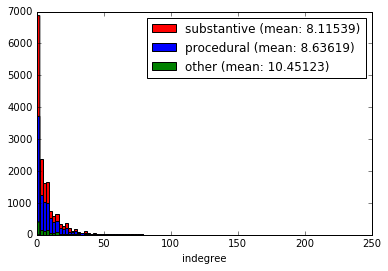

In [185]:

metric = 'indegree'

bins = np.linspace(min(df[metric]), max(df[metric]), 100)

# substantive
plt.hist(df_sub[metric],
         bins=bins,
         color='red',
         label='substantive (mean: %1.5f)' % np.mean(df_sub[metric]))

# procedural
plt.hist(df_pro[metric],
         bins=bins,
         color='blue',
         label='procedural (mean: %1.5f)' % np.mean(df_pro[metric]))

# other
plt.hist(df_oth[metric],
         bins=bins,
         color='green',
         label='other (mean: %1.5f)' % np.mean(df_oth[metric]))

# plt.xlim([0, .2])
# plt.ylim([0, 2000])

plt.xlabel(metric)
plt.legend(loc='upper right')

In [207]:
R = 100

top_cases = df.sort_values(by=metric, ascending=False).iloc[0:R]['type']
top_breakdown = top_cases.value_counts(normalize=True)
all_breakdown = df['type'].value_counts(normalize=True)

top_breakdown - all_breakdown

substantive    0.004262
procedural     0.010959
other         -0.015221
Name: type, dtype: float64